..

Shown below is the parameters input to log_likelihood() as well as the likelihood they give out.

Currently varying Omega_m
0: [  0.     0.73  73.8  -19.2 ] --> Our: -478.714 | Astro: -479.123
0: [ 5.00e-02  7.30e-01  7.38e+01 -1.92e+01] --> Our: -368.201 | Astro: -368.56
0: [  0.1    0.73  73.8  -19.2 ] --> Our: -277.602 | Astro: -277.915
0: [  0.15   0.73  73.8  -19.2 ] --> Our: -204.134 | Astro: -204.402
0: [  0.2    0.73  73.8  -19.2 ] --> Our: -145.659 | Astro: -145.883
0: [  0.25   0.73  73.8  -19.2 ] --> Our: -100.476 | Astro: -100.658
0: [  0.3    0.73  73.8  -19.2 ] --> Our: -67.196 | Astro: -67.337
0: [  0.35   0.73  73.8  -19.2 ] --> Our: -44.659 | Astro: -44.761
0: [  0.4    0.73  73.8  -19.2 ] --> Our: -31.886 | Astro: -31.949
0: [  0.45   0.73  73.8  -19.2 ] --> Our: -28.033 | Astro: -28.059
0: [  0.5    0.73  73.8  -19.2 ] --> Our: -32.372 | Astro: -32.36
0: [  0.55   0.73  73.8  -19.2 ] --> Our: -44.261 | Astro: -44.214
0: [  0.6    0.73  73.8  -19.2 ] --> Our: -63.138 

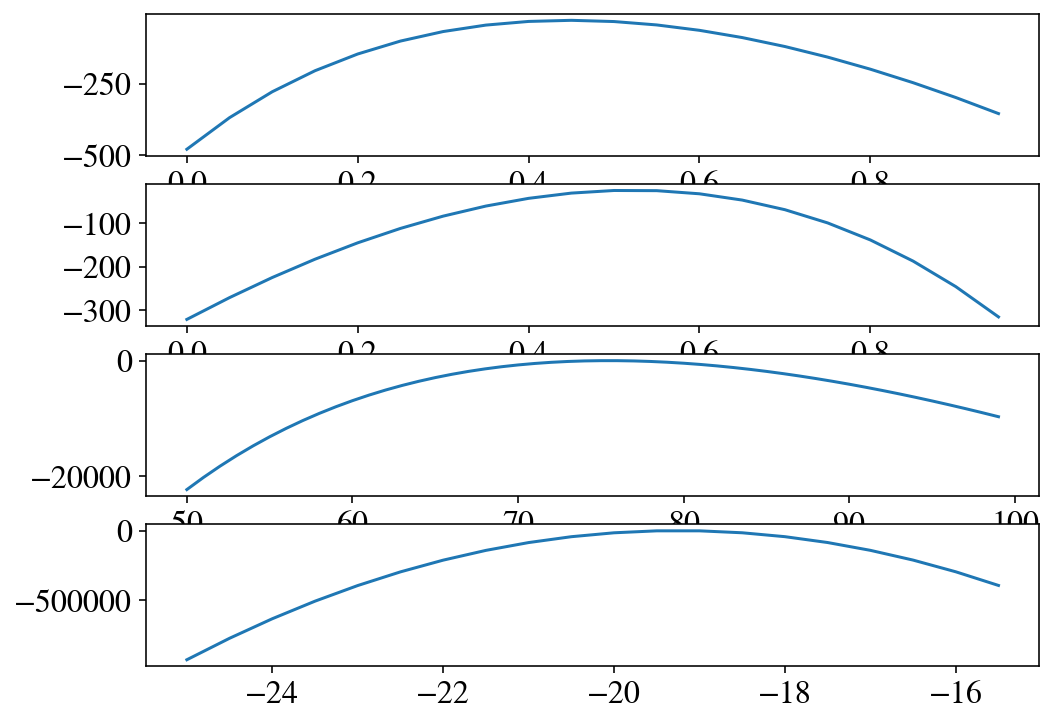

.

Parameter Omega_m has max at 0.45 within range of 0.2 ~ 0.5.
Parameter Omega_m properly has max at 0.5 within range of 0.5 ~ 0.9.
Parameter H0 properly has max at 75 within range of 60 ~ 80.
Parameter M properly has max at -19.0 within range of -22 ~ -18.



----------------------------------------------------------------------
Ran 3 tests in 0.575s

OK


In [23]:
import unittest

if __name__ == "__main__":
    loader = unittest.TestLoader()
    start_dir = "../tests"
    suite = loader.discover(start_dir)
    runner = unittest.TextTestRunner()
    runner.run(suite)

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Union
from getdist import MCSamples, plots
basedir = os.path.dirname(os.path.abspath(''))
sourcedir = os.path.join(basedir, 'source')
import sys
sys.path.insert(0, sourcedir)
from mcmc import MCMC

#################################################
# Setting up plots
#################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

#################################################
# Definitions
#################################################

chains = []  # will contain the main two chains made in this file
# one with systematics, one without systematics

default_chain_length = 10000

names = ["$\Omega_m$", "$\Omega_{\Lambda}$", "$H_0$", "$M$" ]

def make_trace_plot(_chains, labels=names, ylims=None):
    if ylims is None:
        ylims = [[0, 1], [0, 1], [50, 100], [-25, -15]]
    fig, ax = plt.subplots(4,1, figsize=(8, 10))
    if type(_chains) != list:
        _chains = [_chains]
    for chain in _chains:
        for i in np.arange(4):
            ax[i].plot(chain[:,i])
            ax[i].set_ylim(ylims[i])
            ax[i].set_ylabel(labels[i], fontsize=14)
    return fig,ax

#################################################
# Directory setup
#################################################

datadir = os.path.join(basedir, 'data')
binned_data_file = os.path.join(datadir, 'lcparam_DS17f.txt')
binned_sys_file = os.path.join(datadir, 'sys_DS17f.txt')

# With Systematics

## Initial chain to estimate generating function covariance

Below we run a shorter chain to get a rough estimate of the covariance between parameters. This will then be used to run a longer chain for actual parameter estimates.

In [25]:
def make_chain(systematics_file, cov, M_gaussian_prior, chain_length):
    start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
    if M_gaussian_prior:
        start[3] = -19.15

    markov_chain = MCMC(initial_state=start,
                        data_file=binned_data_file,
                        systematics_file=systematics_file,
                        g_cov=cov,
                        M_gaussian_prior=M_gaussian_prior)

    markov_chain.make_chain(chain_length)

    # test values, just to get a sense of the chain
    h0_average = np.average(markov_chain.H0[1000:])
    Omega_m_average = np.average(markov_chain.Omega_m[1000:])
    Omega_L_average = np.average(markov_chain.Omega_L[1000:])
    M_average = np.average(markov_chain.M[1000:])
    assert 50 < np.all(markov_chain.H0[1000:]) < 100, f"Some values for for H0 have fallen out of the expected range"
    assert 0 < np.all(markov_chain.Omega_m[1000:]) < 1, f"Some values for Omega_m have fallen out of the expected range"
    assert 0 < np.all(markov_chain.Omega_L[1000:]) < 1, f"Some values for Omega_L have fallen out of the expected range"
    if not M_gaussian_prior:
        assert -25 < np.all(markov_chain.M[1000:]) < -15, f"Some values for M ({M_average}) has fallen out of the expected range"
    
    print(f"{h0_average=}, {Omega_m_average=}, {Omega_L_average=}, {M_average=}")

    return markov_chain

In [26]:
systematics_markov_chain = make_chain(binned_sys_file,
                                      cov=np.diag([.01, .01, .1, .01]),
                                      M_gaussian_prior=False,
                                      chain_length=default_chain_length)

h0_average=80.72272467084014, Omega_m_average=0.3257742711278388, Omega_L_average=0.7529027812575475, M_average=-19.04426044471777


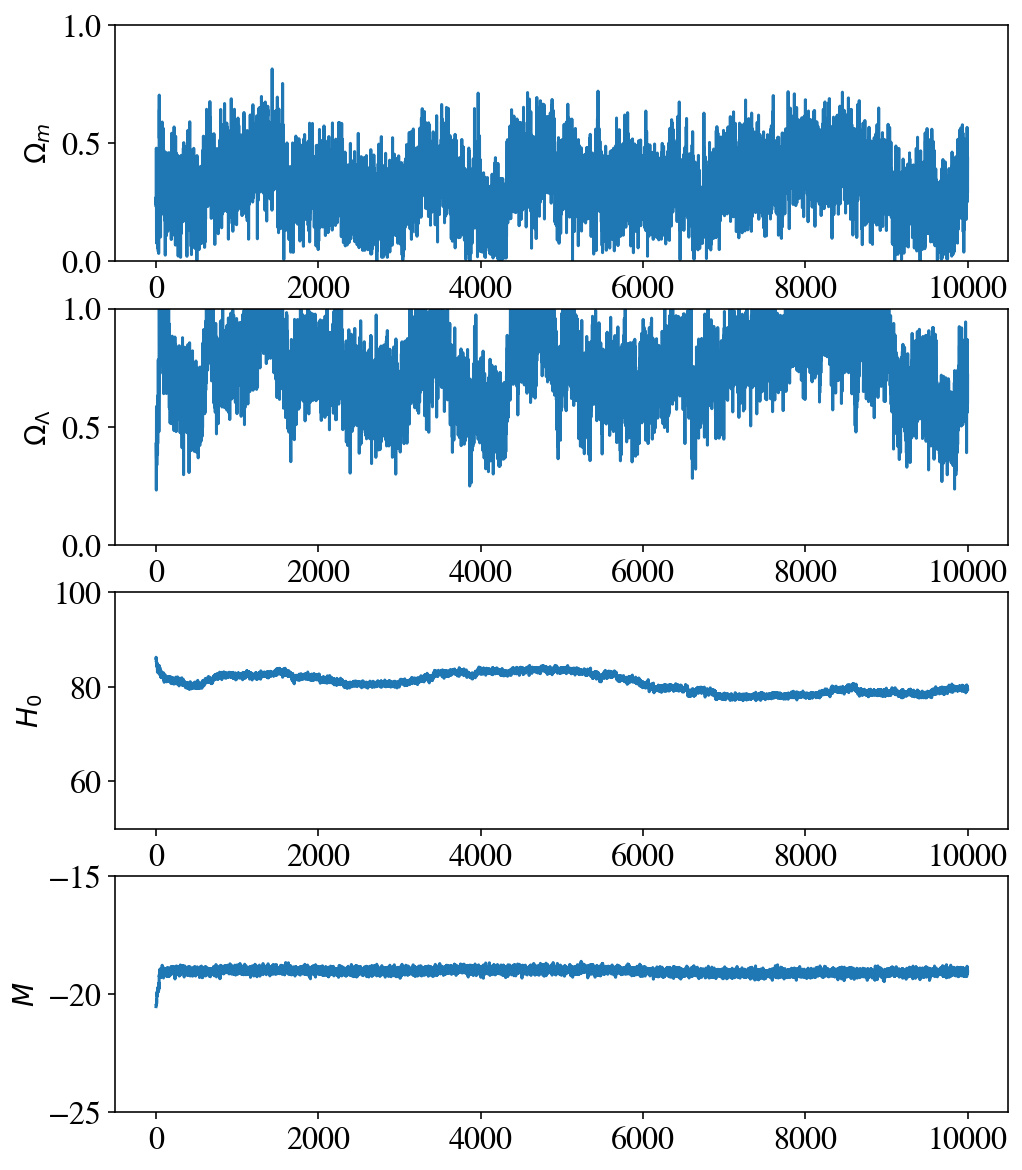

In [27]:
def plot_chain(markov_chain: Union[MCMC, np.ndarray]) -> None:
    """
    Makes a trace plot using make_trace_plot() function above.
    :param markov_chain: Chain object to make a
    """
    if type(markov_chain) == MCMC:
        markov_chain = markov_chain.chain

    _, _ = make_trace_plot(markov_chain)
    plt.show()

plot_chain(systematics_markov_chain)

Now we use the above chains to estimate the parameter covariance, which will be used to refine the generating function on the next run.

In [28]:
def estimate_covariance(markov_chain, burn_in, alpha):
    cov = np.cov(markov_chain.chain[burn_in:, :].T)
    cov *= alpha
    print(cov)
    return cov

systematics_better_cov = estimate_covariance(systematics_markov_chain,
                                             burn_in=500,
                                             alpha=0.1)

[[ 1.55839825e-03  8.28922011e-04  5.42035133e-04 -2.43197066e-05]
 [ 8.28922011e-04  2.51459508e-03 -1.32788553e-03 -1.23554853e-04]
 [ 5.42035133e-04 -1.32788553e-03  3.74530419e-01  1.00396110e-02]
 [-2.43197066e-05 -1.23554853e-04  1.00396110e-02  1.27574283e-03]]


h0_average=75.8803651794003, Omega_m_average=0.32825970719481495, Omega_L_average=0.7500357207107828, M_average=-19.22848988851896


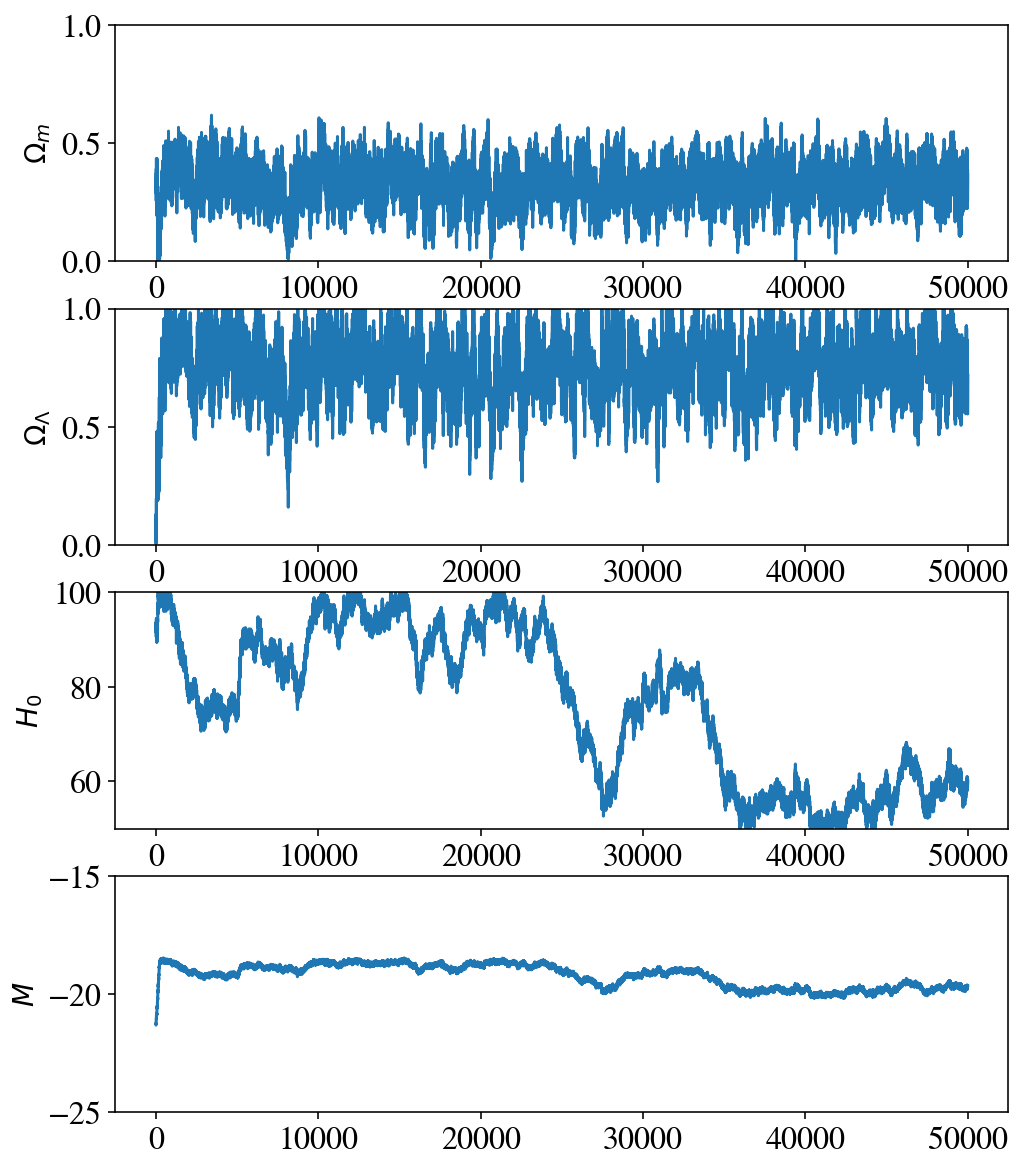

In [29]:
with_systematics_better_cov_chain = make_chain(binned_sys_file,
                                               systematics_better_cov,
                                               M_gaussian_prior=False,
                                               chain_length=default_chain_length*5)

chains.append(with_systematics_better_cov_chain)
plot_chain(with_systematics_better_cov_chain)

# Without Systematics

h0_average=93.11012343311567, Omega_m_average=0.3564990260427038, Omega_L_average=0.8400044972205699, M_average=-18.74753079036314
[[ 1.14033489e-03  1.85102906e-04 -2.45180226e-04 -9.18036354e-06]
 [ 1.85102906e-04  1.37231165e-03 -2.07870571e-04 -1.90896599e-05]
 [-2.45180226e-04 -2.07870571e-04  1.74707976e-01  3.94637816e-03]
 [-9.18036354e-06 -1.90896599e-05  3.94637816e-03  1.09128915e-03]]
h0_average=61.24731787207094, Omega_m_average=0.35332851640982665, Omega_L_average=0.8356253824670434, M_average=-19.674397149914828


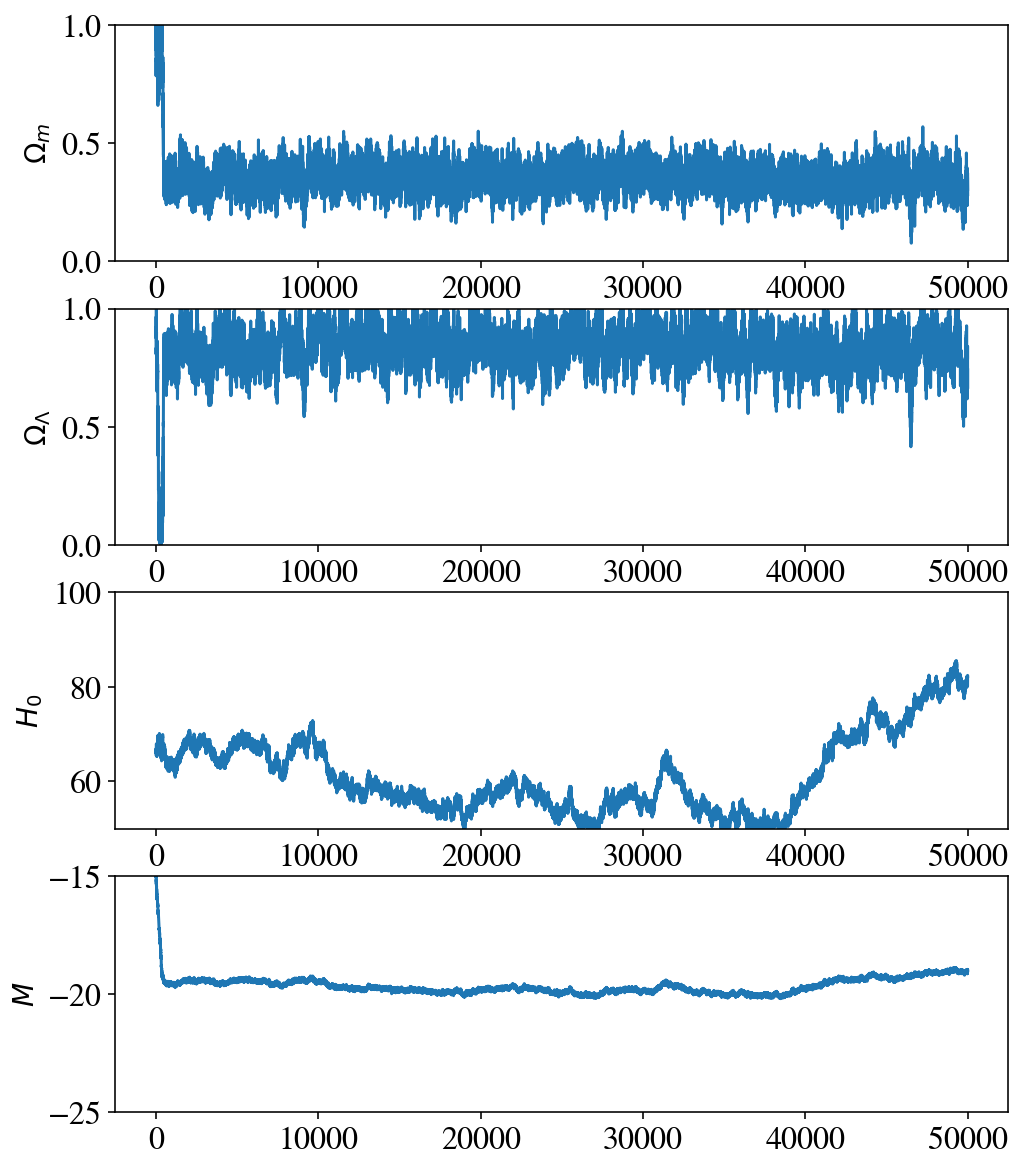

In [30]:
no_systematics_chain = make_chain(systematics_file=None,
                                  cov=np.diag([.01, .01, .1, .01]),
                                  M_gaussian_prior=False,
                                  chain_length=default_chain_length)

no_systematics_better_cov = estimate_covariance(no_systematics_chain,
                                                burn_in=500,
                                                alpha=0.1)

no_systematics_better_cov_chain = make_chain(systematics_file=None,
                                             cov=no_systematics_better_cov,
                                             M_gaussian_prior=False,
                                             chain_length=default_chain_length*5)

chains.append(no_systematics_better_cov_chain)
plot_chain(no_systematics_better_cov_chain)

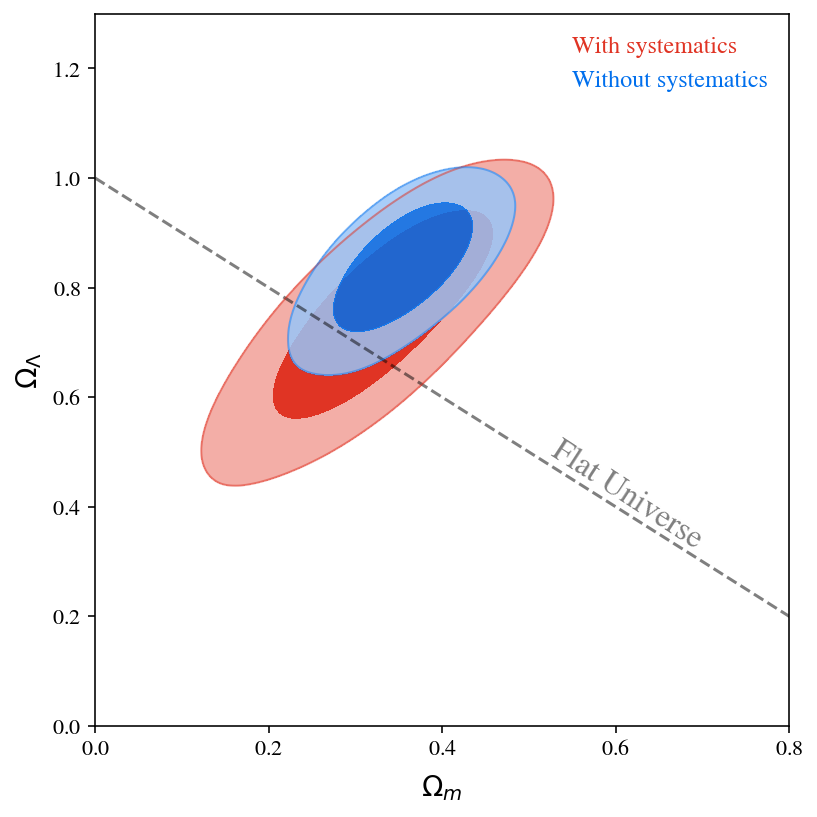

In [31]:
def make_omega_contour_plot():
    burn_in = 1000
    p_names = ['Om', 'Ol', "H0", "M"]
    p_labels = ['\Omega_m', '\Omega_\Lambda', "H_0", "M"]

    sys_samples = MCSamples(samples=with_systematics_better_cov_chain.chain,
                            names = p_names,
                            labels = p_labels,
                            ignore_rows=burn_in)

    no_sys_samples = MCSamples(samples=no_systematics_better_cov_chain.chain,
                               names = p_names,
                               labels = p_labels,
                               ignore_rows=burn_in)

    sys_samples.updateSettings({'contours': [0.68, 0.95]})
    no_sys_samples.updateSettings({'contours': [0.68, 0.95]})
    om_grid = np.linspace(0,1,100)
    g = plots.get_single_plotter(width_inch=6, ratio=1. / 1)
    g.get_axes().plot(om_grid, -om_grid+1, linestyle="dashed", color="k", alpha=0.5)
    g.get_axes().text(0.65, 0.25, 'Flat Universe', rotation=-33, alpha=0.5, transform=g.get_axes().transAxes)
    g.plot_2d([sys_samples, no_sys_samples], p_names[0], p_names[1], filled=True, lims=[0, 0.8, 0, 1.3])

    g.add_legend(['With systematics', 'Without systematics'], colored_text=True)
    return g

omega_contour_plot = make_omega_contour_plot()

In [32]:
def save_omega_contour_plot(graph, save_plot=False):
    resultsdir = os.path.join(basedir, 'results')
    out_name = os.path.join(resultsdir, "omega_contour_plot.pdf")

    if save_plot:
        graph.export(fname=out_name)

save_omega_contour_plot(omega_contour_plot)

# Constraints on $H_0$


h0_average=77.4816347456392, Omega_m_average=0.32904228064627034, Omega_L_average=0.8321726220291485, M_average=-19.160130664784333
[[ 6.76331352e-03  8.35781074e-04 -3.90279798e-02 -7.18325633e-04]
 [ 8.35781074e-04  1.09455555e-02  1.22470396e-01  2.11304022e-03]
 [-3.90279798e-02  1.22470396e-01  7.21484529e+00  1.54011470e-01]
 [-7.18325633e-04  2.11304022e-03  1.54011470e-01  8.50639255e-03]]
h0_average=74.03346408802923, Omega_m_average=0.30921620212236395, Omega_L_average=0.7099045633448097, M_average=-19.229150447058302


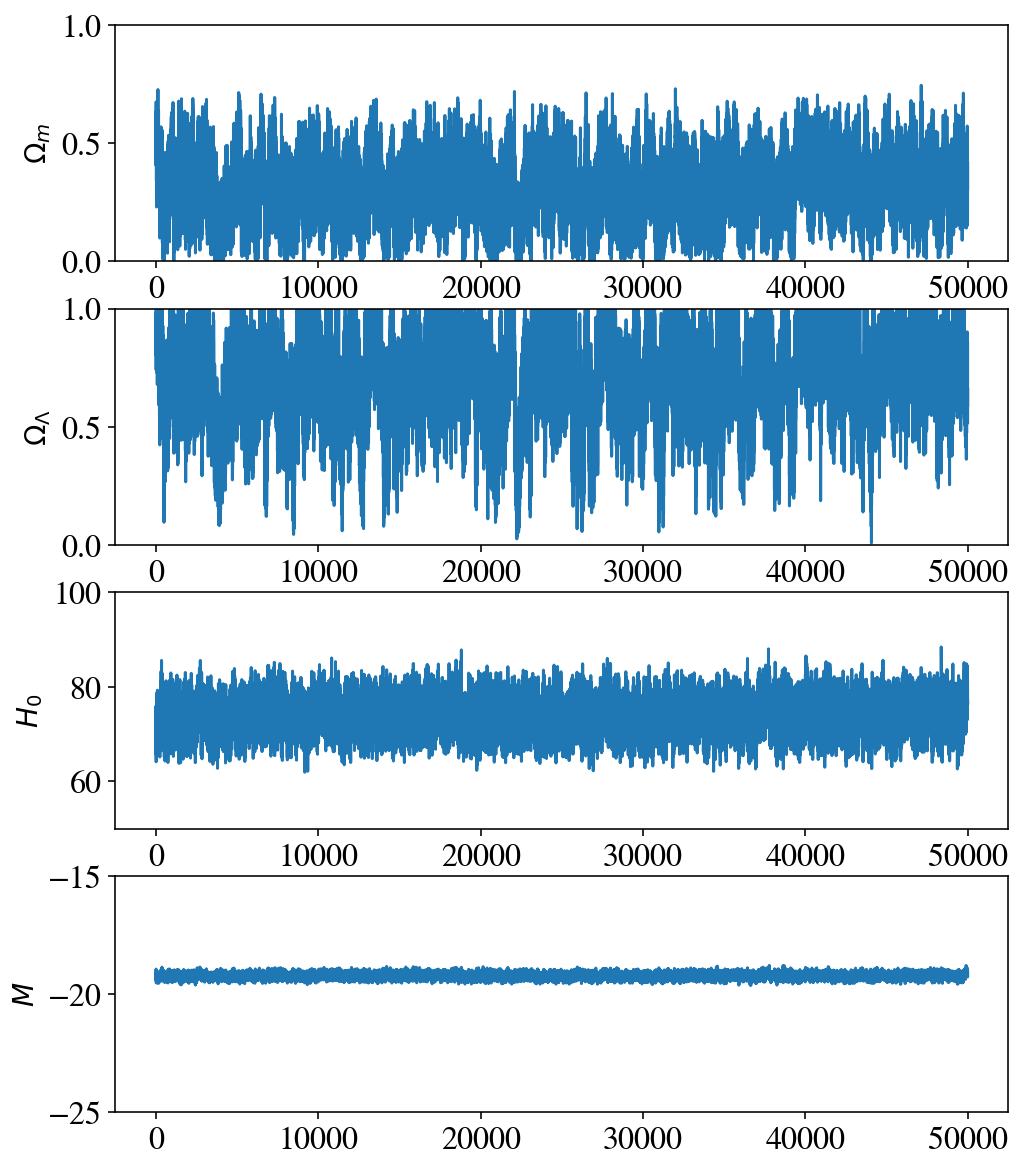

In [35]:
def make_h0_constraints_chain():
    chain = make_chain(systematics_file=binned_sys_file,
                       cov=np.diag([.01, .01, .1, .01]),
                       M_gaussian_prior=True,
                       chain_length=default_chain_length)

    better_cov = estimate_covariance(chain,
                                     burn_in=500,
                                     alpha=0.5)

    chain = make_chain(systematics_file=binned_sys_file,
                       cov=better_cov,
                       M_gaussian_prior=True,
                       chain_length=default_chain_length*5)

    return chain

h0_chain = make_h0_constraints_chain()
plot_chain(h0_chain)

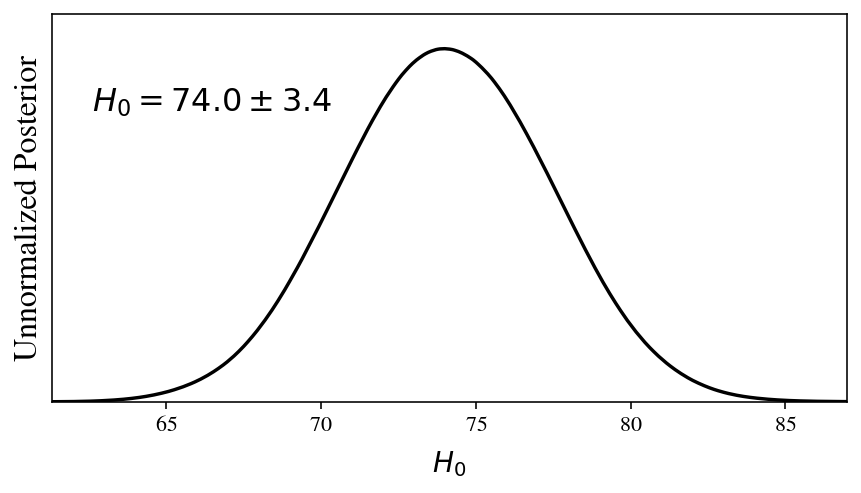

In [36]:
def plot_h0_constraint(markov_chain):
    burn_in = 1000
    p_names = ['Om', 'Ol', "H0", "M"]
    p_labels = ['\Omega_m', '\Omega_\Lambda', "H_0", "M"]
    H0_samples = MCSamples(samples=markov_chain.chain,
                           names = p_names,
                           labels = p_labels,
                           ignore_rows=burn_in)

    limits = "${}$".format(H0_samples.getInlineLatex('H0',limit=1))

    g = plots.get_single_plotter(width_inch=6, ratio=1. / 1.6)
    g.plot_1d(H0_samples, p_names[2])
    g.get_axes().set_ylabel("Unnormalized Posterior")
    g.get_axes().text( 0.05, 0.75, limits, transform=g.get_axes().transAxes)
    return g

h0_plot = plot_h0_constraint(h0_chain)

In [ ]:
def save_h0_contour_plot(graph, save_plot=False):
    resultsdir = os.path.join(basedir, 'results')
    out_name = os.path.join(resultsdir, "H0_posterior_plot.pdf")

    if save_plot:
        graph.export(fname=out_name)

save_h0_contour_plot(h0_plot)